In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
batch_size = 256
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616]),
    ])

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616])
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=val_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
class ZFNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ZFNet, self).__init__()
        # [out_chn, num_layer]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)

        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=256, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=10)

    def forward(self, inputs):
        x = F.relu(self.conv1(inputs))
        x = self.max_pool1(x)

        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        x = x.view(x.size(0), -1)
        x = F.dropout(F.relu(self.fc1(x)))
        x = F.dropout(F.relu(self.fc2(x)))

        model = self.fc3(x)

        return model

In [4]:
model = ZFNet(num_classes=10).to(device)

In [5]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 14, 14]          14,208
         MaxPool2d-2             [-1, 96, 7, 7]               0
            Conv2d-3            [-1, 256, 3, 3]         614,656
         MaxPool2d-4            [-1, 256, 1, 1]               0
            Conv2d-5            [-1, 384, 1, 1]         885,120
            Conv2d-6            [-1, 384, 1, 1]       1,327,488
            Conv2d-7            [-1, 256, 1, 1]         884,992
            Linear-8                 [-1, 4096]       1,052,672
            Linear-9                 [-1, 4096]      16,781,312
           Linear-10                   [-1, 10]          40,970
Total params: 21,601,418
Trainable params: 21,601,418
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.27
Params size (MB): 82.40
Esti

# Train

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)  

In [7]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [8]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 150

In [9]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [  1/150] 	 Loss: 1.82024     Accuracy: 27.63% 	 Test Loss: 1.65546     Test Accuracy: 34.74%
Epoch [  2/150] 	 Loss: 1.52497     Accuracy: 40.89% 	 Test Loss: 1.43588     Test Accuracy: 45.82%
Epoch [  3/150] 	 Loss: 1.32846     Accuracy: 51.01% 	 Test Loss: 1.25024     Test Accuracy: 54.70%
Epoch [  4/150] 	 Loss: 1.17561     Accuracy: 57.73% 	 Test Loss: 1.22574     Test Accuracy: 56.75%
Epoch [  5/150] 	 Loss: 1.06205     Accuracy: 62.38% 	 Test Loss: 1.16222     Test Accuracy: 59.52%
Epoch [  6/150] 	 Loss: 0.96381     Accuracy: 66.46% 	 Test Loss: 1.10631     Test Accuracy: 61.72%
Epoch [  7/150] 	 Loss: 0.89020     Accuracy: 68.81% 	 Test Loss: 1.05924     Test Accuracy: 64.38%
Epoch [  8/150] 	 Loss: 0.81476     Accuracy: 71.81% 	 Test Loss: 1.10998     Test Accuracy: 63.85%
Epoch [  9/150] 	 Loss: 0.74012     Accuracy: 74.60% 	 Test Loss: 1.07324     Test Accuracy: 65.53%
Epoch [ 10/150] 	 Loss: 0.68868     Accuracy: 76.14% 	 Test Loss: 1.05693     Test Accuracy: 66.28%


In [10]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%")


Best epoch: 16 with test accuracy: 67.84%


# Plot results

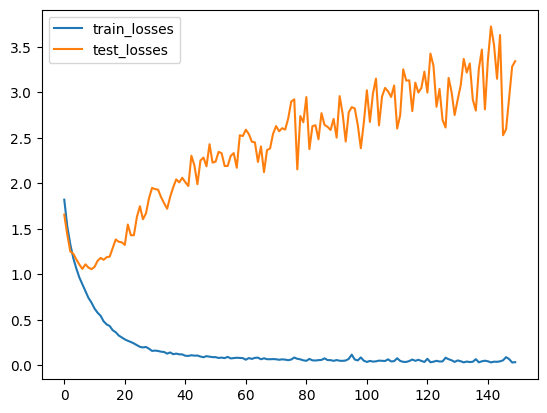

In [11]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

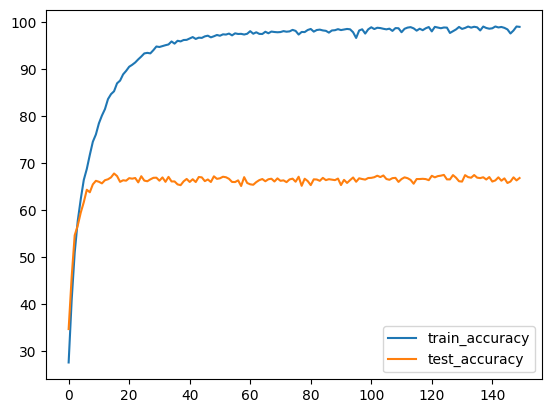

In [12]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()